# Исследование для интернет-магазина: приоритизация гипотез и анализ проведённого A/B-теста

<div style="border:solid black 2px; padding: 20px">    
    Этот проект разделён на две части. В первой мы оценим ряд гипотез двумя способами и выясним, над какими стоит работать в первую очередь. Во второй части проанализируем результаты проведённого A/B тестирования и ответим на такие вопросы: стоит ли продолжать тест и признать ли его успешным или неуспешным в случае остановки
    <br><br>
    Данные:
    <ul>
        <li>Для первой части - файл со списком гипотез и их оценками по параметрам Reach, Impact, Confidence, Effort</li>
        <li>Для второй части - два файла: выгрузка заказов и общее количество пользователей за определённый период</li>
    </ul>
</div>

<i>Загрузим библиотеки, которые понадобятся нам в работе</i>

In [1]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import math

## Приоритизация гипотез

### Подготовка данных

<i>Загрузим данные о гипотезах и посмотрим на них</i>

In [2]:
try:
    data = pd.read_csv('data/hypothesis.csv')
    display(data)
except:
    print('Не удалось загрузить данные о гипотезах. Проверьте правильность пути')

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


<i>У нас небольшой датасет - всего 9 строк, без пропусков и дублей, поэтому результаты можно выводить для всего датасета. Приведём названия столбцов к нижнему регистру. Затем проверим, что преобразование проведено успешно. Заодно уберём ограничение на отображаемую ширину столбца, чтобы прочесть гипотезы полностью</i>

In [3]:
pd.set_option('display.max_colwidth', None)
data.columns = [x.lower() for x in data.columns.values]
data

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<i>Всё хорошо. Теперь можем приступать к приоритизации</i>

### ICE

<i>Для начала применим методику ICE: добавим в данные столбец, посчитанный по соответствующей формуле, а потом выведем отсортированные по этому параметру в порядке убывания гипотезы. Таким образом, наверху окажутся самые приоритетные согласно этой методологии гипотезы</i>

$$ICE = \frac{Impact * Confidence}{Efforts}$$

$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$

In [4]:
data['ICE'] = data['impact'] * data['confidence'] / data['efforts']
data[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


<i>В лидерах гипотезы о запуске акции на день рождения, новых каналах привлечения трафика и о форме подписки на всех основных страницах - и это неудивительно, ведь параметры Impact и Confidence у них наибольшие относительно других. То есть, эти изменения окажут сильное влияние на охватываемую аудиторию. При этом усилия, затрачиваемые на реализацию этих идей, оцениваются средне, есть и те, которые проще значительно имплементировать - однако они сильно проигрывают лидерам по первым двум параметрам</i>

### RICE

<i>Проведём аналогичные расчёты по методологии RICE: добавим в числитель множитель Reach - долю пользователей, которых затронет каждое конкретное изменение</i>

In [5]:
data['RICE'] = data['reach'] * data['impact'] * data['confidence'] / data['efforts']
data[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


<i>Здесь же ситуация изменилась: в лидеры (причём с двукратным отрывом) вырвалась гипотеза 7 - это произошло потому, что параметр Reach у неё максимальный - то есть, это изменение затронет абсолютно всех пользователей сервиса. Наш прошлый лидер - гипотеза 8 - сильно упала в этом рейтинге, ведь это изменение охватывает малый процент пользователей единомоментно (только тех, у кого день рождения). В целом, первая пятёрка осталась прежней, но места распределились иначе</i>

<div style="font-size:2rem; font-weight:bold">Вывод</div>
<p></p>
<div style="border:solid green 2px; padding: 20px">
    <i><b>В зависимости от того, какой способ приоритизиации гипотез используется в компании, следует отдавать предпочтения разным гипотезам. Однако хорошим решением было бы оценить важность идей сразу по обеим шкалам в комплексе - и, таким образом, в первую очередь следовало бы заняться разработкой идей 7 и 0 (они имеют высокую оценку по обеим методикам)</b></i>
</div>

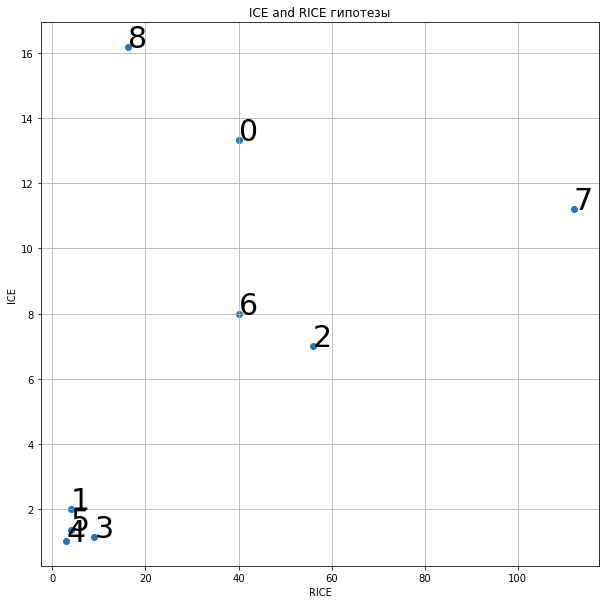

In [6]:
y = data['ICE'] 
z = data['RICE'] 
n = data.index 

fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]), size=30)

plt.title("ICE and RICE гипотезы") 
plt.xlabel("RICE") 
plt.ylabel("ICE")
plt.grid()    
    
fig.set_figheight(10)
fig.set_figwidth(10) 
plt.show() 

In [7]:
coords = pd.concat([y, z], axis=1)

icemax = max(coords['ICE'])
ricemax = max(coords['RICE'])

correct_coeff = icemax / ricemax

coords['distance'] = coords.apply(lambda row: math.sqrt((icemax - row['ICE']) ** 2 + 
                                                        (correct_coeff * (ricemax - row['RICE'])) ** 2), axis=1)
coords.sort_values(by='distance')

,ICE,RICE,distance
7,11.200000,112.0,5.000000
0,13.333333,40.0,10.801626
2,7.000000,56.0,12.257651
6,8.000000,40.0,13.255088
8,16.200000,16.2,13.856786
1,2.000000,4.0,21.110875
3,1.125000,9.0,21.194632
5,1.333333,4.0,21.564944
4,1.000000,3.0,21.899977


## Анализ A/B-теста

### Подготовка данных

<i>Загрузим нужные нам в работе данные, приведём названия столбцов к общему виду (snake case, нижний регистр) и приведём столбцы с датой к типу datetime</i>

In [8]:
try:
    orders = pd.read_csv('data/orders.csv', parse_dates=['date'])
    display(orders.head(10))
except:
    print('Не удалось загрузить данные о заказах. Проверьте правильность пути')

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


In [9]:
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']

<i>Проверим, что все преобразования произведены корректно</i>

In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


<i>Пропусков в данных нет. Проверим, нет ли в них дубликатов</i>

In [11]:
orders.duplicated().sum()

0

<i>Сделаем то же самое с данными о пользователях</i>

In [12]:
try:
    visitors = pd.read_csv('data/visitors.csv', parse_dates=['date'])
    display(visitors)
except:
    print('Не удалось загрузить данные о пользователях. Проверьте правильность пути')

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [13]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


<i>Пропусков нет, ещё проверим данные на наличие дубликатов</i>

In [14]:
visitors.duplicated().sum()

0

<i>Посмотрим, сколько всего групп у нас было в рамках A/B-тестирования</i>

In [15]:
pd.concat([orders['group'], visitors['group']], ignore_index=True).unique()

array(['B', 'A'], dtype=object)

<i>Посмотрим, в течение какого промежутка времени проводился тест</i>

In [16]:
dates = pd.to_datetime(pd.concat([orders['date'], visitors['date']], ignore_index=True).unique())
print('Начало теста:', min(dates.date))
print('Конец теста:', max(dates.date))

Начало теста: 2019-08-01
Конец теста: 2019-08-31


<i>Проверим, нет ли у нас пользователей, попавших одновременно в обе группы. Учитывать их при исследовании результатов A/B-тестирования не совсем корректно, потому что они исказят разницу между двумя группами, и вообще сам факт наличия таких пользователей исказит саму идею такого тестирования. Для начала посмотрим, сколько у нас всего уникальных пользователей, делавших заказы</i>

In [17]:
groups_by_user = orders.groupby('visitor_id')['group'].nunique()
len(groups_by_user)

1031

<i>Теперь проверим, есть ли у нас пользователи, попавшие сразу в обе группы. Выведем их количество</i>

In [18]:
both_groups_ids = groups_by_user.loc[lambda x: x > 1].index
len(both_groups_ids)

58

<i>Их совсем немного относительно общего числа, поэтому данные о них будет верным решением. Так и поступим, а заодно потом проверим, что преобразования проведены корректно</i>

In [19]:
orders = orders[~orders['visitor_id'].isin(both_groups_ids)].reset_index()

In [20]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   index           1016 non-null   int64         
 1   transaction_id  1016 non-null   int64         
 2   visitor_id      1016 non-null   int64         
 3   date            1016 non-null   datetime64[ns]
 4   revenue         1016 non-null   int64         
 5   group           1016 non-null   object        
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 47.8+ KB


<i>Теперь для вывода графиков кумулятивных показателей нам нужно собрать таблицу с кумулятивными данными</i>

In [21]:
# создаём массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о пользователях 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# выведем первые 5 строк итоговой таблицы
cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


<i>Проверим, правильно ли был собран новый датафрейм. Выведем минимальную и максимальную даты - они должны соответствовать исходным данным, 1 августа и 31 августа соответственно</i>

In [22]:
print('Минимальная дата в общей таблице:', min(cumulativeData['date']))
print('Максимальная дата в общей таблице:', max(cumulativeData['date']))

Минимальная дата в общей таблице: 2019-08-01 00:00:00
Максимальная дата в общей таблице: 2019-08-31 00:00:00


<i>Из нашей общей таблицы выделим кумулятивные данные для каждой из групп и сохраним их в отдельные датафреймы</i>

In [23]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeDataA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders', 'visitors']]

# добавим ещё столбец с кумулятивным количеством дней - он пригодится нам позже
cumulativeDataA.reset_index(drop=True, inplace=True)
cumulativeDataA['days'] = (cumulativeDataA.index + 1)

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders', 'visitors']]

# добавим ещё столбец с кумулятивным количеством дней - он пригодится нам позже
cumulativeDataB.reset_index(drop=True, inplace=True)
cumulativeDataB['days'] = (cumulativeDataB.index + 1)

### Кумулятивная выручка по группам

<i>Построим графики кумулятивной выручки по дням и группам A/B тестирования</i>

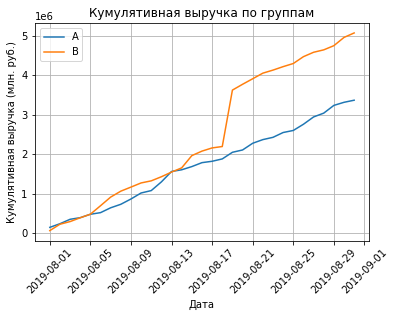

In [24]:
# Строим график выручки группы А
plt.plot(cumulativeDataA['date'], cumulativeDataA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeDataB['date'], cumulativeDataB['revenue'], label='B')

plt.title('Кумулятивная выручка по группам')
plt.xticks(rotation = 45)
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка (млн. руб.)')
plt.legend()
plt.grid()
plt.show();

<div style="border:solid black 1px; padding: 10px"><i>Выручка увеличивается со временем - это первый признак того, что данные построены верно. Однако для группы B выручка растёт неравномерно - после 17 августа наблюдается большой всплеск. Наверняка это следствие какого-то выброса (очень дорогого заказа)</i></div>

### Кумулятивный средний чек по группам

<i>Построим графики кумулятивного среднего по дням и группам A/B тестирования</i>

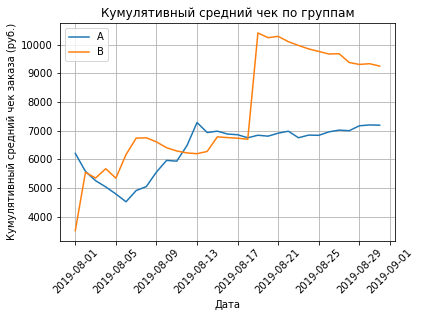

In [25]:
# Строим график среднего чека группы А
plt.plot(cumulativeDataA['date'], cumulativeDataA['revenue']/cumulativeDataA['orders'], label='A')

# Строим график среднего чека группы B
plt.plot(cumulativeDataB['date'], cumulativeDataB['revenue']/cumulativeDataB['orders'], label='B')

plt.title('Кумулятивный средний чек по группам')
plt.xticks(rotation = 45)
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек заказа (руб.)')
plt.legend()
plt.grid()
plt.show();

<div style="border:solid black 1px; padding: 10px"><i>В начале исследования график среднего чека испытывает сильные колебания - значения не устанавливаются на одном уровне. Опять же, после 17 августа - большой всплеск для группы B, после которого, однако, наблюдается постоянное снижение. Похоже, в этой группе после этой даты снижались темпы прироста количества заказов. Проверим далее положение дел за вычетом выбросов</i></div>

### Относительное изменение кумулятивного среднего чека

<i>Посмотрим, как различаются средние чеки в обеих группах друг относительно друга</i>

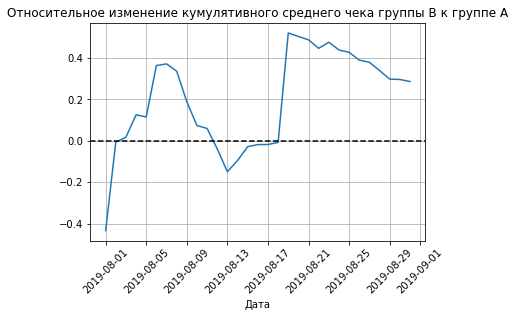

In [26]:
# собираем данные в одном датафрейме
mergedCumulativeData = cumulativeDataA.merge(cumulativeDataB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeData['date'], (mergedCumulativeData['revenueB']/mergedCumulativeData['ordersB'])/(mergedCumulativeData['revenueA']/mergedCumulativeData['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.title('Относительное изменение кумулятивного среднего чека группы В к группе А')
plt.xticks(rotation = 45)
plt.xlabel('Дата')
plt.grid()
plt.show();

<div style="border:solid black 1px; padding: 10px"><i>И здесь нет чётко устоявшейся тенденции - сначала группа В проигрывает группе А, потом опережает, затем снова проигрывает, и потом, благодаря нескольким крупным заказам, значительно вырывается вперёд</i></div>

### Кумулятивное среднее количество заказов по группам

<i>Построим график кумулятивного среднего количества заказов по группам. Для этого суммарное количество заказов разделим на суммарное количество дней, за которое эти заказы были сделаны</i>

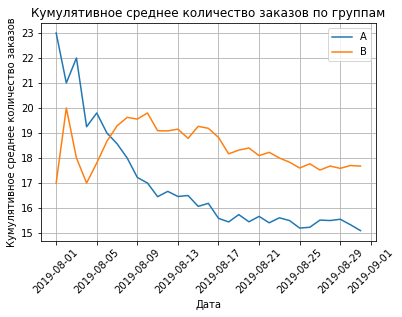

In [27]:
# Строим график среднего количества заказов группы А
plt.plot(cumulativeDataA['date'], cumulativeDataA['orders']/cumulativeDataA['days'], label='A')

# Строим график среднего количества заказов группы B
plt.plot(cumulativeDataB['date'], cumulativeDataB['orders']/cumulativeDataB['days'], label='B')

plt.title('Кумулятивное среднее количество заказов по группам')
plt.xticks(rotation = 45)
plt.xlabel('Дата')
plt.ylabel('Кумулятивное среднее количество заказов')
plt.legend()
plt.grid()
plt.show();

<i>Посмотрим ещё на график такой величины, как отношение кумулятивного количества заказов к кумулятивному же количеству посетителей интернет-магазина</i>

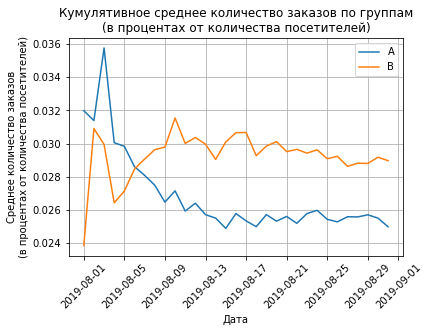

In [28]:
# Строим график среднего количества заказов группы А
plt.plot(cumulativeDataA['date'], cumulativeDataA['orders']/cumulativeDataA['visitors'], label='A')

# Строим график среднего количества заказов группы B
plt.plot(cumulativeDataB['date'], cumulativeDataB['orders']/cumulativeDataB['visitors'], label='B')

plt.title('Кумулятивное среднее количество заказов по группам\n(в процентах от количества посетителей)')
plt.xticks(rotation = 45)
plt.xlabel('Дата')
plt.ylabel('Среднее количество заказов\n(в процентах от количества посетителей)')
plt.legend()
plt.grid()
plt.show();

<div style="border:solid black 1px; padding: 10px"><i>Среднее количество заказов в группе В со временем становится больше и так и удерживается (на 2-3 заказа в день в среднем больше, чес в группе А)</i></div>

### Относительное изменение кумулятивного среднего количества заказов

<i>Построим теперь график отношения кумулятивного среднего количества заказов по группам</i>

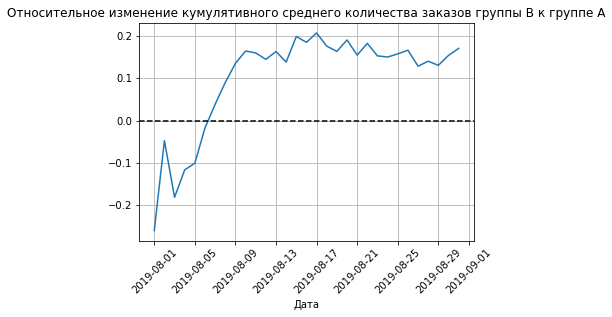

In [29]:
# cтроим отношение среднего количества заказов
plt.plot(mergedCumulativeData['date'], (mergedCumulativeData['ordersB']/mergedCumulativeData['daysB'])/(mergedCumulativeData['ordersA']/mergedCumulativeData['daysA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.title('Относительное изменение кумулятивного среднего количества заказов группы В к группе А')
plt.xticks(rotation = 45)
plt.xlabel('Дата')
plt.grid()
plt.show();

<div style="border:solid black 1px; padding: 10px"><i>В группе В в среднем на 15 процентов заказов больше, чем в группе А - и это уже устоявшийся факт</i></div>

### Количество заказов по пользователям

<i>Подготовим данные: для каждого пользователя укажем количество заказов, сделанных им</i>

In [30]:
ordersByUsers = orders.groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'})

ordersByUsers.columns = ['visitor_id', 'orders']

ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,visitor_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


<i>Теперь посмотрим на распределение количества заказов на графике</i>

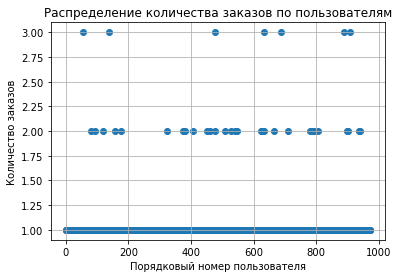

In [31]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])
plt.xlabel('Порядковый номер пользователя')
plt.ylabel('Количество заказов')
plt.title('Распределение количества заказов по пользователям')
plt.grid();

<i>Подавляющее количество пользователей совершает 1-2 заказа. Посмотрим теперь соответствующие 95 и 99 перцентили</i>

In [32]:
display(np.percentile(ordersByUsers['orders'], [95, 99]))
orders_max = np.percentile(ordersByUsers['orders'], [95, 99])[1]

array([1., 2.])

<div style="border:solid black 1px; padding: 10px"><i>95 процентов пользователей не совершают больше 1 заказа, а 99 процентов - не больше 2. Будем считать выбросами всех, сделавших более 2 заказов, чтобы отбросить 1 процент аномальных значений. Сохраним этот порог в отдельную переменную</i></div>

### Стоимость заказов

<i>Посмотрим на распределение стоимостей заказов</i>

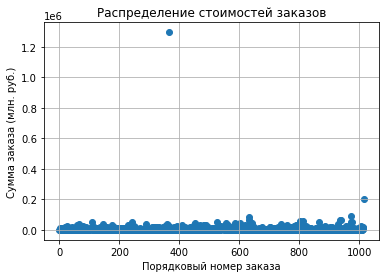

In [33]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.xlabel('Порядковый номер заказа')
plt.ylabel('Сумма заказа (млн. руб.)')
plt.title('Распределение стоимостей заказов')
plt.grid();

<i>Этот график малоинформативен из-за одного выброса (очень большое значения, больше 1 миллиона - вероятно, это и есть тот заказ, который исказил кумулятивные графики в группе В). Посмотрим на распределение стоимостей заказов в меньшем диапазоне</i>

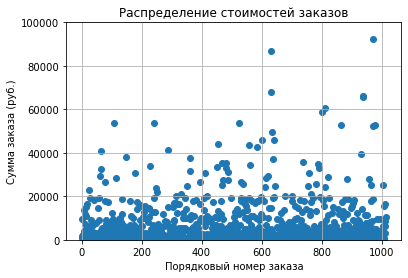

In [34]:
plt.scatter(x_values, orders['revenue'])
plt.ylim(0, 100000)
plt.xlabel('Порядковый номер заказа')
plt.ylabel('Сумма заказа (руб.)')
plt.title('Распределение стоимостей заказов')
plt.grid()

<i>Здесь уже лучше видно, что большинство заказов - стоимостью примерно до 40000 тысяч рублей. Выведем соответствующие 95 и 99 перцентили</i>

In [35]:
display(np.percentile(orders['revenue'], [95, 99]))
revenue_max = np.percentile(orders['revenue'], [95, 99])[1]

array([26785., 53904.])

<div style="border:solid black 1px; padding: 10px"><i>Будем считать выбросами те заказы, стоимость которых превышает 54 тысячи рублей. Таким образом отбросим 1% аномальных значений. Сохраним этот порог также в отдельную переменную</i></div>

### Статистическая значимость различий в среднем количестве заказов между группами по сырым данным

<i>Подготовим данные. Сначала рассчитаем общее количество пользователей в каждой группе в каждый день эксперимента</i>

In [36]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']


data = (
    visitorsADaily.merge(
        visitorsBDaily, left_on='date', right_on='date', how='left'
    )
)

print(data.head(5)) 

        date  visitorsPerDateA  visitorsPerDateB
0 2019-08-01               719               713
1 2019-08-02               619               581
2 2019-08-03               507               509
3 2019-08-04               717               770
4 2019-08-05               756               707


<i>Теперь для каждой группы посчитаем количество заказов на каждого пользователя</i>

In [37]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsersB.columns = ['visitor_id', 'orders'] 

<i>Дополним выборки по группам данными о тех пользователях, которые не совершали покупки - определим, что количество заказов для них равно 0</i>

In [38]:
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

<i>
    <u>Нулевая гипотеза:</u> значимых различий в среднем количестве заказов между группами нет<br>
    <u>Альтернативная гипотеза:</u> в среднем количестве заказов есть значимые различия<br>
    Проверим p-value
</i>

In [39]:
round(stats.mannwhitneyu(sampleA, sampleB)[1], 3)

0.011

<i>p-value меньше уровня 0.05, поэтому мы отвергаем нулевую гипотезу - среднее количество заказов между группами всё-таки значимо отличается. Посмотрим на процентное соотношение этой величины между группами</i>

In [40]:
round(sampleB.mean() / sampleA.mean() - 1, 3)

0.16

<div style="border:solid black 1px; padding: 10px"><i>Среднее количество заказов значимо различается между группами - в группе В оно выше на 16%</i></div>

### Статистическая значимость различий в среднем чеке заказа между группами по сырым данным

<i>Проверим значимость различий в среднем чеке между группами<br>
    <u>Нулевая гипотеза:</u> значимых различий в среднем чеке между группами нет<br>
    <u>Альтернативная гипотеза:</u> есть значимые различия в среднем чеке между группами
</i>

In [41]:
round(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1], 3)

0.829

<i>p-value значительно больше 0.05, поэтому нулевая гипотеза подтверждается. Посмотрим ещё на соотношение среднего чека между группами</i>

In [42]:
round(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1, 3)

0.287

<div style="border:solid black 1px; padding: 10px"><i>Хоть средний чек группы В и больше среднего чека группы А почти на 29 процентов, основания считать различие статистически значимым у нас нет. Это довольно неожиданный вывод, учитывая такую большую относительную разницу, поэтому стоит проверить наши гипотезы на отфильтрованных данных. Похоже, здесь мы как раз  наблюдаем влияние этих единичных выбросов, которые изменили соотношение среднего чека в пользу группы В</i></div>

### Статистическая значимость различий в среднем количестве заказов между группами по очищенным данным

<i>Выводы, сделанные в предыдущих разделах, были основаны на полных, "сырых" данных, куда входили и выбросы. Правильнее будет произвести сравнение групп без выбросов, тем более что мы уже устанавливали пороги для них. Выделим всех пользователей, подходящих под определение "аномальные" в рамках нашего исследования, в отдельный датасет</i>

In [43]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsers[ordersByUsers['orders'] > orders_max]['visitor_id'],
    ],
    axis=0,
)

usersWithExpensiveOrders = orders[orders['revenue'] > revenue_max]['visitor_id']

abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

<i>Теперь в sampleA и sampleB будем определять только тех пользователей, чьи id не находятся в списке "аномальных"</i>

In [44]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

<i>
    <u>Нулевая гипотеза:</u> значимых различий в среднем количестве заказов между группами нет<br>
    <u>Альтернативная гипотеза:</u> в среднем количестве заказов есть значимые различия<br>
    Проверим p-value
</i>

In [45]:
round(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1], 3)

0.007

<i>Нулевая гипотеза не подтвердилась и на очищенных данных - всё так же среднее количество заказов значимо различается. Посмотрим на соотношение этой величины в группе А к группе В</i>

In [46]:
round(sampleBFiltered.mean()/sampleAFiltered.mean()-1, 3)

0.189

<div style="border:solid black 1px; padding: 10px"><i>И на отфильтрованных данных мы также отвергаем нулевую гипотезу - среднее количество заказов между группами значимо различается, причём относительная разница между группами увеличилась до 17.8%</i></div>

### Статистическая значимость различий в среднем чеке заказа между группами по очищенным данным

<i>Проверим значимость различий в среднем чеке между группами по очищенным данным<br>
    <u>Нулевая гипотеза:</u> значимых различий в среднем чеке между группами нет<br>
    <u>Альтернативная гипотеза:</u> есть значимые различия в среднем чеке между группами
</i>

In [47]:
round(
    stats.mannwhitneyu(
        orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'],
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'],
    )[1], 3
)

0.788

In [48]:
round(
    orders[
        np.logical_and(
            orders['group'] == 'B',
            np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
        )
    ]['revenue'].mean()
    / orders[
        np.logical_and(
            orders['group'] == 'A',
            np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
    ]['revenue'].mean()
    - 1, 3
)

-0.032

<div style="border:solid black 1px; padding: 10px"><i>На очищенных данных мы получаем корректные данные - средний чек заказа всё так же значимо не различается, при этом относительная разница между группами сильно сократилась - с 29 до 5 процентов. Это уже похоже на правду</i></div>

<div style="font-size:2rem; font-weight:bold">Вывод</div>
<p></p>
<div style="border:solid green 2px; padding: 20px">
    <i><b>Выручка складывается из двух составляющих: количества заказов и среднего чека. И хотя в ходе нашего исследования удалось значимо увеличить только один из этих параметров, (второй остался на том же уровне, увеличившись незначительно), эксперимент можно останавливать и признать его удавшимся, так как выручка в тестовой группе увеличилась за счёт увеличения количества заказов</b></i>
</div>